# Sparkify Project Workspace

This project is about identifying customers of music streaming services that are going to churn. It PySpark.  

In [1]:
# import libraries
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, LongType, TimestampType
from pyspark import SparkContext
from pyspark.sql.window import Window
from pyspark.sql.functions import * 
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import datetime
import matplotlib.pyplot as plt

In [2]:
# create a Spark session

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("Sparkify Project") \
    .getOrCreate()


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json("mini_sparkify_event_data.json")

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# drop null values and empty user IDs

df_valid = df.dropna(how = "any", subset = ["userId", "sessionId", "page"])
df_valid = df_valid.select("userId").dropDuplicates().sort("userId")
df_valid = df.filter(df["userId"] != "")
df_valid.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

# Data Exploration


### Explore Page Column

'Page' column is an important one as it gives information about different user behaviours. Let's explore it further with a bar plot. 

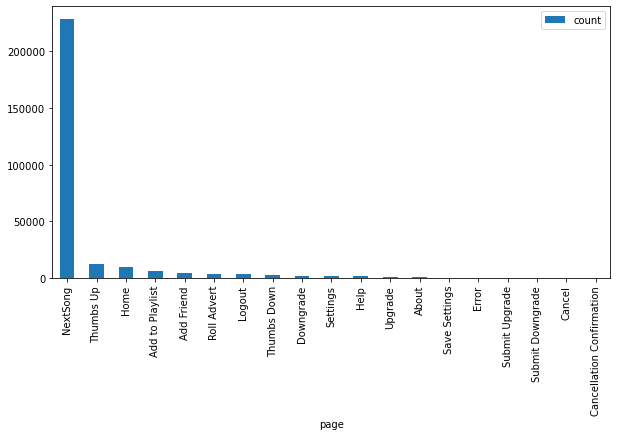

In [10]:
page_counts = df_valid.groupBy('page').count()
page_counts_df = page_counts.orderBy(col("count").desc()).toPandas()
fig = page_counts_df.plot(kind='bar',x='page', y='count', figsize=(10,5)).get_figure()
fig.savefig("page_bar.png")

Most users have selected NextSong, let's filter this out to better see the distribution of the other user behaviours. 

In [ ]:
page_counts_filtered_df = page_counts_df[page_counts_df['page']!='NextSong']
page_counts_filtered_df.plot(kind='bar',x='page', y='count', figsize=(12,6))

### Define Churn

Next, we define churn - this in terms of cancellation confirmation and downgrade-related events. Even if dowgrade does not necessarily mean the customer would definitely leave, it is an indicator of potentially decreasing customer satisfaction, lower revenue for the streaming service and also an indicator that the customer might change their mind if they're shown some love and attention. So these are the events we want to be able to identify.    

In [ ]:
#UDFs
def is_churn_event(x):
    
    '''Flags churn events. Returns 1 for churn, 0 for no-churn.'''
    
    if x in ["Cancellation Confirmation", "Downgrade", "Submit Downgrade"]:
        return 1
    else:
        return 0 


### Define Happy and Unhappy User Behaviours

The Page column includes other user behaviours that are essential for the analysis - I split them into positive/ happy user events and negative/ unhappy events. 

In [ ]:
def is_happy_event(x):
    
    '''Flags happy events. Returns 1 for happy events, 0 otherwise.'''
    
    if x in ["NextSong", "Thumbs Up", "Add Friend", "Add to Playlist", "Upgrade", "Submit Upgrade"]:
        return 1
    else:
        return 0
    
def is_unhappy_event(x):
    
    '''Flags unhappy events. Returns 1 for unhappy events, 0 otherwise.'''
    
    if x in ["Thumbs Down", "Error", "Cancel", ]:
        return 1
    else:
        return 0

In [ ]:
## define UDFs

churn_event = udf(is_churn_event, IntegerType())
happy_event = udf(is_happy_event, IntegerType())
unhappy_event = udf(is_unhappy_event, IntegerType())

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). day)

In [ ]:
## Add Churn/ Happy / Unhappy events to dataframe
## Add Hour / Day / Interaction time features to dataframe
df_valid =  df_valid.withColumn("churn", churn_event("page"))\
            .withColumn("happyEvent", happy_event("page"))\
            .withColumn("unhappyEvent", unhappy_event("page"))\
            .withColumn("hour", get_hour("ts").cast('int'))\
            .withColumn("day", get_day("ts").cast('int'))\
            .withColumn('interactionTime', from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType()))


# Flag rows for churn / happy / unhappy events.
user_window = Window\
                .partitionBy("userId")\
                .orderBy(desc("ts"))\
                .rangeBetween(Window.unboundedPreceding, 0)

df_valid = df_valid\
            .withColumn("churn", max("churn").over(user_window))\
            .withColumn("happyEvent", max("happyEvent").over(user_window))\
            .withColumn("unhappyEvent", max("unhappyEvent").over(user_window))


In [ ]:
df_valid.head()


# Feature Exploration 

### User Journey

Let's see the journey of a single customer who cancelled. 

In [ ]:
# find users who cancelled
df_valid.select(['userID']).where(df_valid.churn==1).dropDuplicates().show()


In [ ]:
# pick one
user_cancelled_df = df_valid.select(["firstName", "page", "level", "song", 
                                  "hour", "day", "interactionTime", 
                                  "happyEvent", "unhappyEvent"]).where(df_valid.userId == 101).toPandas()
user_cancelled_df.head()

In [ ]:
## Print some stats about this particular user journey

print(f"Alex's Membership Days : {user_cancelled_df.day.max()}")
print(f"Numbers of Songs Alex Listened to: {user_cancelled_df[user_cancelled_df['page']=='NextSong']['page'].count()}")
print(f"Alex's Happy Events: {user_cancelled_df.happyEvent.sum()}")
print(f"Alex's Unhappy Events: {user_cancelled_df.unhappyEvent.sum()}")


## Compare Features between Churn and No-Churn User Groups

### Churn by Level - Free vs Paid

In [ ]:
churn_by_level_df = df_valid.select('userId','level','churn')\
                                    .groupby('churn','level')\
                                    .agg(countDistinct('userId'))\
                                    .withColumnRenamed('count(DISTINCT userId)', 'count')\
                                    .toPandas()


In [ ]:
churn_by_level_df.pivot(index='churn', columns='level', values='count').plot(kind='bar')

### Churn by Number of Sessions

In [ ]:
churn_by_sessions_df = df_valid.select("sessionId", "churn")\
                                .groupby('churn')\
                                .agg(countDistinct('sessionId'))\
                                .withColumnRenamed('count(DISTINCT sessionId)', 'sessionsCount').toPandas().set_index('churn')

In [ ]:
churn_by_sessions_df.plot(kind='bar',)

### Churn by Number of Songs 

In [ ]:
churn_by_songs_df = df_valid.select("userId", "churn","page")\
                            .where(df_valid.page == "NextSong")\
                            .groupby("churn")\
                            .agg(countDistinct("userId"))\
                            .withColumnRenamed('count(DISTINCT userId)', 'songsCount').toPandas().set_index('churn')

In [ ]:
churn_by_songs_df.plot(kind='bar')

### Churn by Gender

In [ ]:
churn_by_gender_df = df_valid.select('userId', 'churn', 'gender')\
                             .groupby(['churn', 'gender'])\
                             .agg(countDistinct('userId'))\
                             .withColumnRenamed('count(DISTINCT userId)', 'userCount').toPandas()

In [ ]:
churn_by_gender_df.pivot(index='churn', columns='gender', values='userCount').plot(kind='bar')

### Churn by Happy Events

In [ ]:
churn_by_happy_events_df = df_valid.select('userId', 'churn', 'happyEvent')\
                                   .groupby('churn')\
                                   .agg(sum('happyEvent'))\
                                   .withColumnRenamed('sum(happyEvent)', 'happyEvents').toPandas().set_index('churn')

In [ ]:
churn_by_happy_events_df.plot(kind='bar')

In [ ]:
#churn by unhappy event
churn_by_unhappy_events_df = df_valid.select('userId', 'churn', 'unhappyEvent')\
                                   .groupby('churn')\
                                   .agg(sum('unhappyEvent'))\
                                   .withColumnRenamed('sum(unhappyEvent)', 'unhappyEvents').toPandas().set_index('churn')

### Churn by Unhappy Events

In [ ]:
churn_by_unhappy_events_df.plot(kind='bar')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [ ]:
# number of songs played
songs_count_df = df_valid.select(['userId', 'page',]).where(df.page == 'NextSong') \
                                .groupby('userId') \
                                .agg({'page':'count'}) \
                                .withColumnRenamed('count(page)', 'songsCount')


In [ ]:
#count number of sessions

sessions_count_df = df_valid.select(['userId', 'sessionId'])\
                            .groupby('userId')\
                            .agg({'sessionId': 'count'})\
                            .withColumnRenamed('count(sessionId)', 'sessionsCount')


In [ ]:
#membership period
membership_days_df = df_valid.select(['userId', 'day'])\
                            .groupby('userId')\
                            .agg(max('day'))\
                            .withColumnRenamed('max(day)', 'membershipDays')


In [ ]:
#happy events count
happy_events_count_df = df_valid.select(['userId', 'happyEvent',])\
                                .groupby('userId') \
                                .agg(sum('happyEvent'))\
                                .withColumnRenamed('sum(happyEvent)','happyEventCount')

In [ ]:
unhappy_events_count_df = df_valid.select(['userId', 'unhappyEvent',])\
                                .groupby('userId') \
                                .agg(sum('unhappyEvent'))\
                                .withColumnRenamed('sum(unhappyEvent)','unhappyEventCount')

In [ ]:
churn_event_df = df_valid.select(['userId', 'churn',])\
                                .groupby('userId')\
                                .agg(max('churn'))\
                                .withColumnRenamed('max(churn)', 'label')

In [ ]:
data = songs_count_df.join(sessions_count_df, 'userId', 'outer') \
                     .join(membership_days_df, 'userId', 'outer')\
                     .join(happy_events_count_df, 'userId', 'outer')\
                     .join(unhappy_events_count_df, 'userId', 'outer')\
                     .join(churn_event_df, 'userId', 'outer')


In [ ]:
pd.DataFrame(data.take(5), columns=data.columns)

In [ ]:
data.printSchema()

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [ ]:
train, test = data.randomSplit([0.7, 0.3], seed=27)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))


In [ ]:
features = ['songsCount' , 'sessionsCount', 
            'membershipDays' , 'happyEventCount', 
            'unhappyEventCount' 
           ]

classifiers = [ RandomForestClassifier(featuresCol = 'features', labelCol = 'label'), 
                LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10), 
                GBTClassifier(maxIter=10)
              ]
classifier_names = [ "Random Forest Classifier", 
                     "Logistic Regression", 
                     "Gradient-Boosted Tree Classifier"
                   ]


In [ ]:
def build_model_pipeline (classifier, train): 
    
    '''Input is a classifier and data for training
    Returns fitted model. 
    '''
    
    vectorAssembler = VectorAssembler(inputCols=features, \
                                      outputCol="unscaled_features"
                                     )
    standardScaler = StandardScaler(inputCol="unscaled_features", 
                                    outputCol="features"
                                   )
    stages = [vectorAssembler, standardScaler, classifier]
    pipeline = Pipeline(stages=stages)
    model = pipeline.fit(train)
    
    return model
    

## Evaluation

In [ ]:
def evaluate_model (model, train, test):
    
    '''Takes as input a fitted model, train data and test data.
    Returns evaluation results: 
    f1 score on train data
    ROC AUC metric on train data
    f1 score on test data
    ROC AUC metric on test data
    '''
    
    # instantiate evaluators 
    binary_evaluator = BinaryClassificationEvaluator(labelCol='label')
    multi_evaluator = MulticlassClassificationEvaluator(labelCol='label')
    
    # make predictions  
    predictions_train = model.transform(train)
    predictions_test = model.transform(test)
    
    f1_train = multi_evaluator.evaluate(predictions_train, {multi_evaluator.metricName: 'f1'})
    roc_train = binary_evaluator.evaluate(predictions_train, {binary_evaluator.metricName: 'areaUnderROC'})
    
    f1_test = multi_evaluator.evaluate(predictions_test, {multi_evaluator.metricName: 'f1'})
    roc_test = binary_evaluator.evaluate(predictions_test, {binary_evaluator.metricName: 'areaUnderROC'})
    
    results = [ f1_train, roc_train, f1_test, roc_test ]
    return results


    

In [ ]:
all_results = dict()

for classifier, name in zip(classifiers, classifier_names):
    
    model = build_model_pipeline(classifier, train)
    result = evaluate_model(model, train, test)
    all_results[name] = result
    


In [ ]:
results_df = pd.DataFrame.from_dict(all_results, orient='index', columns=['F1 Train', 'ROC Train', 'F1 Test', 'ROC Test'])
results_df

## Parameter Tuning

In [ ]:
best_classifier =  LogisticRegression(maxIter=10)

vectorAssembler = VectorAssembler(inputCols=features, \
                                      outputCol="unscaled_features"
                                     )
standardScaler = StandardScaler(inputCol="unscaled_features", 
                                    outputCol="features"
                                   )
stages = [vectorAssembler, standardScaler, best_classifier]
pipeline = Pipeline(stages=stages)
    

paramGrid = ParamGridBuilder() \
            .addGrid(best_classifier.regParam, [0.01, 0.1,]) \
            .addGrid(best_classifier.elasticNetParam, [0.0, 0.5, 1.0])\
            .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3
                          )

In [ ]:
cv_model = crossval.fit(train)
predictions = cv_model.transform(test)
binary_evaluator = BinaryClassificationEvaluator(labelCol='label')
multi_evaluator = MulticlassClassificationEvaluator(labelCol='label')
print("Area Under ROC", binary_evaluator.evaluate(predictions))
print("F1", multi_evaluator.evaluate(predictions))

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.